# Classification of earthquakes signals using autoencoders

Dataset: http://www.timeseriesclassification.com/description.php?Dataset=Earthquakes

We study the two different types of autoencoders which are constructed by the following layers:
<li> Dense
<li> Convolutional 
<br>
    <br>
We adopt them to classify the negative and positive cases, where the data is imbalanced. We compare the performance of these two methods.

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import tensorflow as tf
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, jaccard_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv1DTranspose, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Load the data

In [2]:
train = arff.loadarff('Earthquakes_TRAIN.arff')
test = arff.loadarff('Earthquakes_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

In [4]:
train['target'].value_counts()

b'0'    264
b'1'     58
Name: target, dtype: int64

In [5]:
positive_train = train[train.target==b'1']
negative_train = train[train.target==b'0']
positive_test = test[test.target==b'1']
negative_test = test[test.target==b'0']

In [6]:
negative_train_X = negative_train.iloc[:,:-1].values
negative_test_X = negative_test.iloc[:,:-1].values
positive_train_X = positive_train.iloc[:,:-1].values
positive_test_X = positive_test.iloc[:,:-1].values

In [7]:
test_X = test.iloc[:,:-1].values

Label the data 

In [8]:
le = LabelEncoder()
train_y =le.fit_transform(train.iloc[:,-1])
test_y =le.transform(test.iloc[:,-1])

In [9]:
values, counts = np.unique(train_y, return_counts=True)
print("Labels: ", dict(zip(values, counts)))

Labels:  {0: 264, 1: 58}


Label 0 as negative and 1 as positive

# Autoencoder

In [10]:
#Number of epochs
epochs = 500

# batch size
batch_size = 8

# verbose
verbose = 0

In [11]:
output_size = negative_train_X.shape[1]

In [12]:
input_shape = (negative_train_X.shape[1],)

In [13]:
def autoencoder(input_shape, output_size):
    '''
    This autoencoder is constructed by Dense layer.
    '''
    model = Sequential()
    model.add(Dense(512, activation="swish", input_shape=input_shape))
    model.add(Dropout(rate=0.2))
    model.add(Dense(320, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(256, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(16, activation="swish"))
    model.add(Dense(32, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(256, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(320, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(512, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(output_size, activation="softmax"))
    model.compile(loss='mse', 
                optimizer=Adam(learning_rate=0.00002))
    model.summary()
    return model

In [14]:
model = autoencoder(input_shape, output_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 320)               164160    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               82176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [15]:
start = time()
history = model.fit(negative_train_X, negative_train_X, epochs=epochs, verbose=verbose, 
                    batch_size=batch_size, validation_split=0.2, shuffle=False)
end = time()
print("Training time: ", end - start)

Training time:  68.59594869613647


Text(0, 0.5, 'Loss')

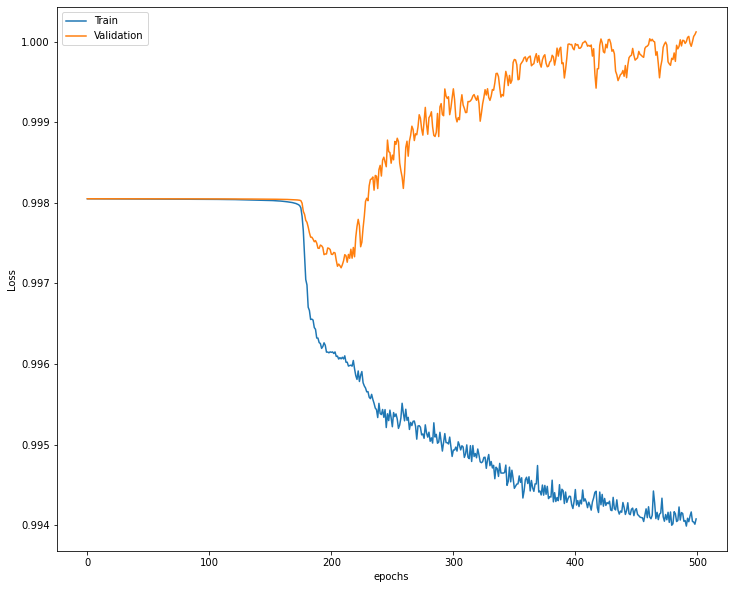

In [16]:
# Plot for train losses
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.rc('font', size=10)
plt.xlabel("epochs")
plt.ylabel('Loss')

In [17]:
def reconstruct_err(model, data):
    reconstructions = model.predict(data)
    err = mean_squared_error(data.T, reconstructions.T, multioutput='raw_values')
    return err

In [18]:
negative_err = reconstruct_err(model, negative_train_X)
positive_err = reconstruct_err(model, positive_train_X)

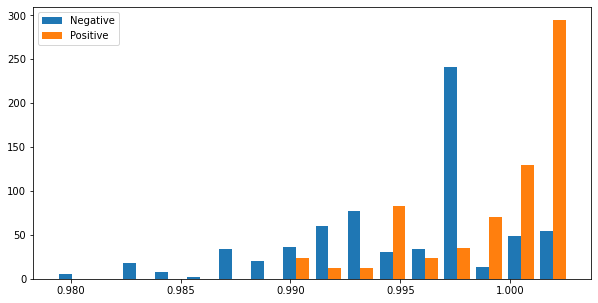

In [19]:
bins = int(np.sqrt(negative_err.shape[0]))
plt.figure(figsize=(10,5))
plt.hist([negative_err, positive_err], bins, label=['Negative', 'Positive'], density=True)
plt.legend()
plt.show()

In [20]:
diff = []
negative_percentile = []
positive_percentile = []
for i in range(1,100):
    diff.append(np.abs(np.percentile(negative_err, i) - np.percentile(positive_err, 100-i)))
    negative_percentile.append(np.percentile(negative_err, i))
    positive_percentile.append(np.percentile(positive_err, 100-i))

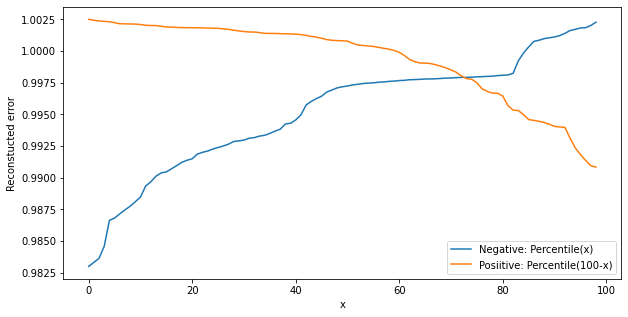

In [21]:
plt.figure(figsize=(10,5))
plt.plot(negative_percentile, label='Negative: Percentile(x)')
plt.plot(positive_percentile, label='Posiitive: Percentile(100-x)')
plt.legend()
plt.ylabel('Reconstucted error')
plt.xlabel('x')
plt.show()

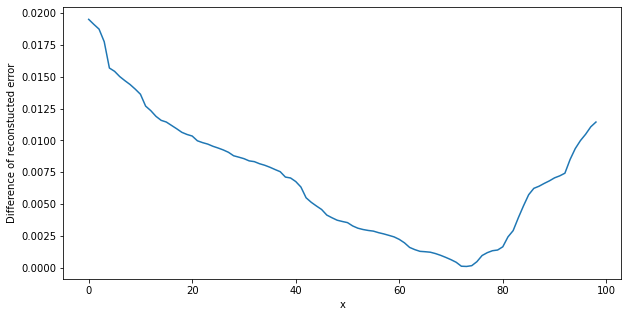

In [22]:
plt.figure(figsize=(10,5))
plt.plot(diff)
plt.ylabel('Difference of reconstucted error')
plt.xlabel('x')
plt.show()

In [23]:
min_index = np.argmin(diff)
threshold = np.percentile(negative_err, min_index) 

In [24]:
err = reconstruct_err(model, test_X)

In [25]:
def prediction(model, err, test_X):
    index = np.where(err>threshold)
    index = list(index[0])
    size = test_y.shape[0]

    return [1 if x in index else 0 for x in range(size)]

In [26]:
pred = prediction(model, err, test_X)

In [27]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    acc = accuracy_score(truedata, pred)
    f1 = f1_score(truedata, pred)
    jaccard = jaccard_score(truedata, pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    gmean = np.sqrt(sensitivity*specificity)
    print("Accuracy: ", round(acc,3))
    print("F1 score: ", round(f1,3))
    print("Jaccard Score: ", round(jaccard,3))
    print("G-Mean: ", round(gmean,3))
    return [acc, f1, jaccard, gmean]

In [28]:
column = ['Accuracy', 'F1 Score', 'Jaccard Score', 'G-Mean']
metrics = pd.DataFrame(columns=column)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index = []
metrics_index.append('Autoencoder')

Metrics
True positive:  26
True negative:  35
False positive:  69
False negative:  9

Accuracy:  0.439
F1 score:  0.4
Jaccard Score:  0.25
G-Mean:  0.5


# Convolutational Autoencoder

In [29]:
#Number of epochs
epochs = 300

# batch size
batch_size = 8

# verbose
verbose = 0

In [30]:
output_size = negative_train_X.shape[1]

In [31]:
negative_train_X = negative_train_X.reshape((negative_train_X.shape[0], negative_train_X.shape[1], 1))
negative_test_X = negative_test_X.reshape((negative_test_X.shape[0], negative_test_X.shape[1], 1))
positive_train_X = positive_train_X.reshape((positive_train_X.shape[0], positive_train_X.shape[1], 1))
positive_test_X = positive_test_X.reshape((positive_test_X.shape[0], positive_test_X.shape[1], 1))

In [32]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

In [33]:
input_shape = (negative_train_X.shape[1], 1)

In [34]:
def convolutionalautoencoder(input_shape):
    '''
    This model adopt the convolutional layer to construct the autoencoder.
    '''
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=9, padding="same", strides=2, activation="swish", input_shape=input_shape))
    model.add(Dropout(rate=0.2))
    model.add(Conv1D(filters=64, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Conv1D(filters=32, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Conv1D(filters=16, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Conv1DTranspose(filters=16, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Conv1DTranspose(filters=32, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.1))
    model.add(Conv1DTranspose(filters=64, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Conv1DTranspose(filters=128, kernel_size=9, padding="same", strides=2, activation="swish"))
    model.add(Dropout(rate=0.2))
    model.add(Conv1DTranspose(filters=1, kernel_size=9, padding="same"))
    model.compile(optimizer=Adam(learning_rate=0.0005),loss="mse")
    model.summary()
    return model

In [35]:
model = convolutionalautoencoder(input_shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 128)          1280      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           73792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 32)            18464     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 16)           

In [36]:
start = time()
history = model.fit(negative_train_X, negative_train_X, epochs=epochs, verbose=verbose, 
                    batch_size=batch_size, validation_split=0.1, shuffle=False)
end = time()
print("Training time: ", end - start)

Training time:  408.7722828388214


Text(0, 0.5, 'Loss')

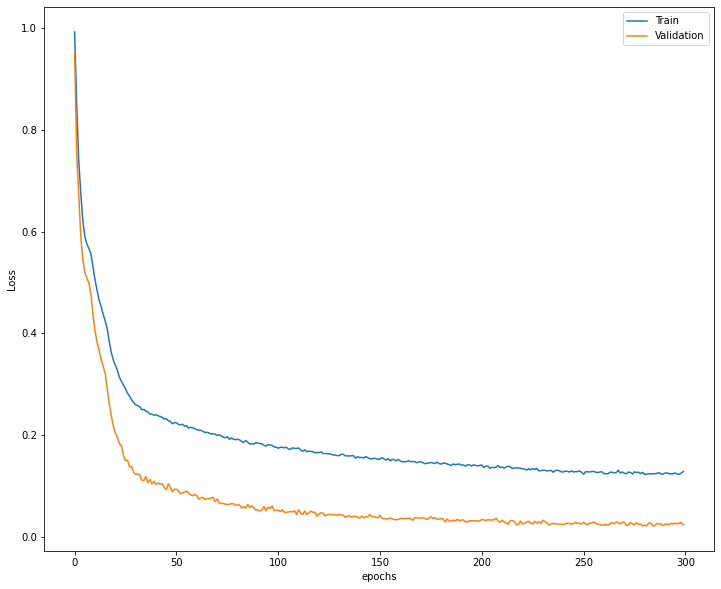

In [37]:
# Plot for train losses
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.rc('font', size=10)
plt.xlabel("epochs")
plt.ylabel('Loss')

In [38]:
def conv_reconstruct_err(model, data):
    reconstructions = model.predict(data)[:,:,0]
    err = mean_squared_error(data[:,:,0].T, reconstructions.T, multioutput='raw_values')
    return err

In [39]:
negative_err = conv_reconstruct_err(model, negative_train_X)
positive_err = conv_reconstruct_err(model, positive_train_X)

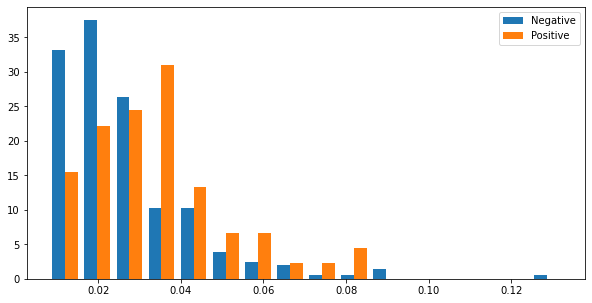

In [40]:
bins = int(np.sqrt(negative_err.shape[0]))
plt.figure(figsize=(10,5))
plt.hist([negative_err, positive_err], bins, label=['Negative', 'Positive'], density=True)
plt.legend()
plt.show()

In [41]:
diff = []
negative_percentile = []
positive_percentile = []
for i in range(1,100):
    diff.append(np.abs(np.percentile(negative_err, i) - np.percentile(positive_err, 100-i)))
    negative_percentile.append(np.percentile(negative_err, i))
    positive_percentile.append(np.percentile(positive_err, 100-i))

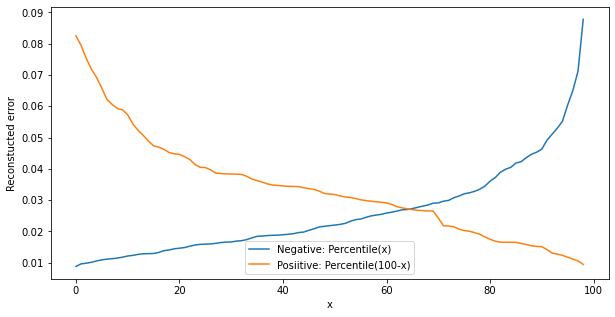

In [42]:
plt.figure(figsize=(10,5))
plt.plot(negative_percentile, label='Negative: Percentile(x)')
plt.plot(positive_percentile, label='Posiitive: Percentile(100-x)')
plt.legend()
plt.ylabel('Reconstucted error')
plt.xlabel('x')
plt.show()

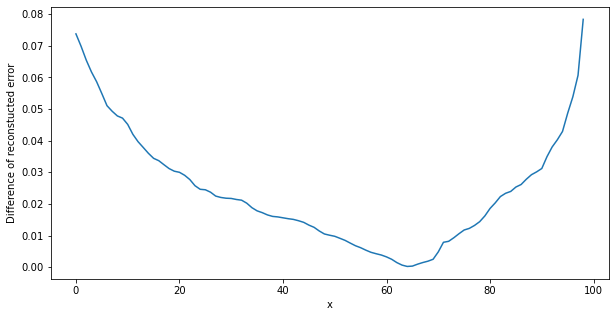

In [43]:
plt.figure(figsize=(10,5))
plt.plot(diff)
plt.ylabel('Difference of reconstucted error')
plt.xlabel('x')
plt.show()

In [44]:
min_index = np.argmin(diff)
threshold = np.percentile(negative_err, min_index) 

In [45]:
err = conv_reconstruct_err(model, test_X)

In [46]:
pred = prediction(model, err, test_X)

In [47]:
temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('ConvolutionalAutoencoder')

Metrics
True positive:  21
True negative:  51
False positive:  53
False negative:  14

Accuracy:  0.518
F1 score:  0.385
Jaccard Score:  0.239
G-Mean:  0.542


# Summary

In [48]:
metrics.index = metrics_index
metrics

,Accuracy,F1 Score,Jaccard Score,G-Mean
Autoencoder,0.438849,0.400000,0.250000,0.50000
ConvolutionalAutoencoder,0.517986,0.385321,0.238636,0.54243


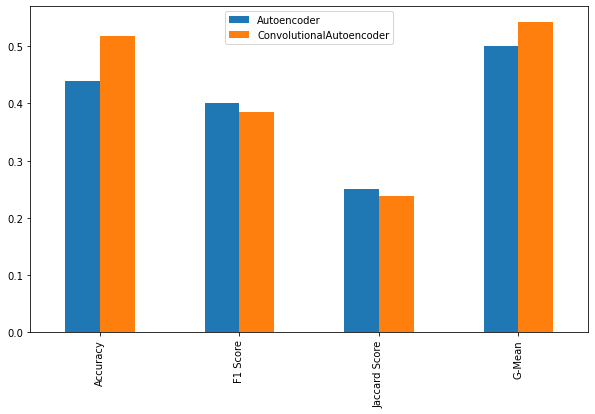

In [49]:
metrics.T.plot(kind='bar', figsize=(10,6))
plt.show()

Both models can give high F1, Jaccord scores and G-Mean. However, their accuracies are lower than the other methods.